In [1]:
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
# initial values
C0 = [1.0, 0.0, 0.0]
# parameters - these can vary when used with a financial model, eg. for calibration
# in financial models a large bunch of values need to be used for applying nets in there...
k1 = -0.5 + 0.002* np.random.rand() #-0.5
k2 = 0.0 #+ np.random.rand()
k3 = 0.0 #+ np.random.rand()
k4 = 0.25 + 0.25 * np.random.rand() #0.5
k5 = -0.25 + 0.0025 * np.random.rand() #-0.25
k6 = 0.0
k7 = 0.0
k8 = -0.25 + 0.25 * np.random.rand() #0.25
k9 = -0.125 + 0.25 * np.random.rand() #-1/6

def ode(t, C):
# Simple system of Ordinary Differential Equations
# for financial models Ricatti Equations play a prominent role
# Eg SV models, IR (Quasi) Gauss models
    Ca, Cb, Cc = C
    
    # The system of ODE
    dCadt = k1 * Ca + k2 * Cb + k3 * Cc
    dCbdt = k4 * Ca + k5 * Cb + k6 * Cc
    dCcdt = k7 * Ca + k8 * Cb + k9 * Cc
    
    return [dCadt, dCbdt, dCcdt]


Text(0, 0.5, 'C')

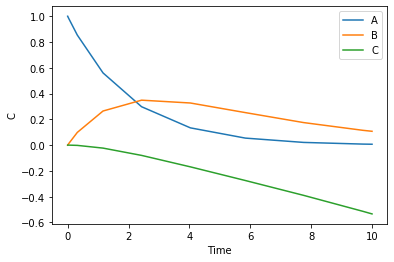

In [3]:
# numerical ode solver
# if an analytical solution is known this could of course be used
sol = solve_ivp(ode, (0, 10), C0)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T)
plt.legend(['A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')

In [6]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

In [7]:
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def swish(x):
    "see https://arxiv.org/pdf/1710.05941.pdf"
    return x / (1.0 + np.exp(-x))

def mrelu(x):
    return abs(x) * (x > 0)

def C(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)
        #inputs = mrelu(outputs)
    return outputs

# initial guess for the weights and biases
params = init_random_params(0.1, layer_sizes=[1, 4, 4, 3])

Text(0, 0.5, 'C')

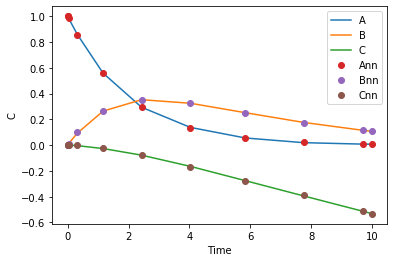

In [8]:
def objective_soln(params, step):
    return np.sum((sol.y.T - C(params, sol.t.reshape([-1, 1])))**2)

params = adam(grad(objective_soln), params,
              step_size=0.001, num_iters=5000)

plt.plot(sol.t.reshape([-1, 1]), C(params, sol.t.reshape([-1, 1])),
         sol.t, sol.y.T, 'o')
plt.legend(['A', 'B', 'C', 'Ann', 'Bnn', 'Cnn'])
plt.xlabel('Time')
plt.ylabel('C')

In [9]:
# Derivatives
jac = jacobian(C, 1)

def dCdt(params, t):
    i = np.arange(len(t))
    return jac(params, t)[i, :, i].reshape((len(t), 3))

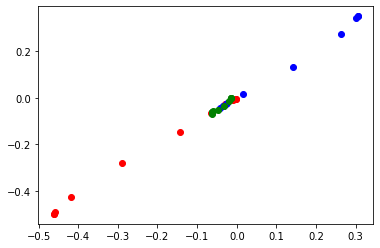

In [10]:
jacC = jacobian(C, 1)
jacC(params, sol.t.reshape([-1, 1])).shape

i = np.arange(len(sol.t))
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 0, i, 0],   k1 * sol.y[0] + k2 * sol.y[1] + k3 * sol.y[2], 'ro')
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 1, i, 0],   k4 * sol.y[0] + k5 * sol.y[1] + k6 * sol.y[2], 'bo')
plt.plot(jacC(params, sol.t.reshape([-1, 1]))[i, 2, i, 0],   k7 * sol.y[0] + k8 * sol.y[1] + k9 * sol.y[2], 'go')

In [11]:
t = np.linspace(0, 10, 25).reshape((-1, 1))
params = init_random_params(0.1, layer_sizes=[1, 8, 3])
i = 0    # number of training steps
N = 5001  # epochs for training
et = 0.0 # total elapsed time

In [12]:
def objective(params, step):
    Ca, Cb, Cc = C(params, t).T
    dCadt, dCbdt, dCcdt = dCdt(params, t).T
    
    z1 = np.sum((dCadt - k1 * Ca - k2 * Cb - k3 * Cc)**2)
    z2 = np.sum((dCbdt - k4 * Ca - k5 * Cb - k6 * Cc)**2)
    z3 = np.sum((dCcdt - k7 * Ca - k8 * Cb - k9 * Cc)**2)
    ic = np.sum((np.array([Ca[0], Cb[0], Cc[0]]) - C0)**2)  # initial conditions
    return z1 + z2 + z3 + ic

def callback(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))

objective(params, 0)  # make sure the objective is scalar

1.673313026195998

In [13]:
import time
t0 = time.time()

params = adam(grad(objective), params,
              step_size=0.001, num_iters=N, callback=callback)

i += N
t1 = (time.time() - t0) / 60
et += t1

#plt.plot(t, C(params, t), sol.t, sol.y.T, 'o')
#plt.legend(['Ann', 'Bnn', 'Cnn', 'A', 'B', 'C'])
#plt.xlabel('Time')
#plt.ylabel('C')
print(f'{t1:1.1f} minutes elapsed this time. Total time = {et:1.2f} min. Total epochs = {i}.')

Iteration   0 objective 1.673313026195998
Iteration 1000 objective 0.022711391031496476
Iteration 2000 objective 0.005583121377917798
Iteration 3000 objective 0.002604454457831655
Iteration 4000 objective 0.002118008594572354
Iteration 5000 objective 0.0018735253766102536
3.2 minutes elapsed this time. Total time = 3.24 min. Total epochs = 5001.


Text(0, 0.5, 'C')

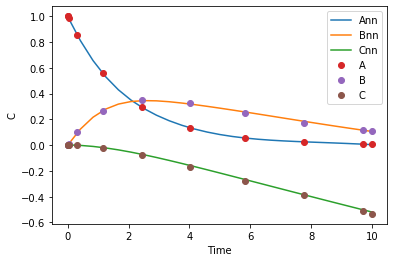

In [14]:
plt.plot(t, C(params, t), sol.t, sol.y.T, 'o')
plt.legend(['Ann', 'Bnn', 'Cnn', 'A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')

Text(0, 0.5, 'C')

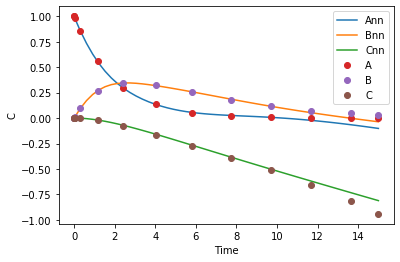

In [15]:
# Extrapolation
lb = 0.0
ub = 15.0
t = np.linspace(lb, ub, 50).reshape((-1, 1))

sol_t = solve_ivp(ode, (lb, ub), C0)

plt.plot(t, C(params, t), sol_t.t, sol_t.y.T, 'o')
plt.legend(['Ann', 'Bnn', 'Cnn', 'A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')

In [16]:
import autograd.numpy as anp
NN_Layers = 2             # Number of Hidden Layers
NN_Nodes = [3, 7, 7, 1]   # Number of Nodes per Layer, first is input dimension, last is output dimension
N_Input = 3

from scipy.stats import truncnorm
def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

Weights = []
Bias  = []

# preparing for flowing the input layer
for i in range(1,NN_Layers+2):
    rad = 1 / anp.sqrt(NN_Nodes[i])
    X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
    Weights.append(X.rvs((NN_Nodes[i-1], NN_Nodes[i])))
    Bias.append(anp.random.rand())

W = [[], []]
for i in range(NN_Layers+1):
    W[0].append(Weights[i])
    W[1].append(Bias[i])

def WNeuralNetwork(w,x):
    input1=x
    for i in range(NN_Layers):
        input1=anp.dot(input1,w[0][i])+w[1][i]
        #Elu activation
        input1=elu(input1)
    #The output layer is linear
    i+=1
    return np.dot(input1,w[0][i])+w[1][i]


def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=anp.exp(x[ind])-1
    return x

def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=anp.exp(x[ind])
    x[~ind]=1
    return x

def NeuralNetwork(x):
    input1=x
    for i in range(NN_Layers):
        input1=anp.dot(input1,Weights[i])+Bias[i]
        #Elu activation
        input1=elu(input1)
    #The output layer is linear
    i+=1
    return np.dot(input1,Weights[i])+Bias[i]

def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=anp.eye(N_Input)
    #Propagate the gradient via chain rule
    for i in range(NN_Layers):
        input1=(anp.dot(input1,Weights[i])+Bias[i])
        grad=(anp.einsum('ij,jk->ik', grad, Weights[i]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,Weights[i])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

In [17]:
W = [[], []]
for i in range(NN_Layers+1):
    W[0].append(Weights[i])
    W[1].append(Bias[i])

In [18]:
x_i = np.array([1, 2, 3])
print(x_i)

[1 2 3]


In [19]:
NeuralNetwork(x_i)

array([0.90937299])

In [20]:
WNeuralNetwork(W,x_i)

array([0.90937299])

In [21]:
NeuralNetworkGradient(x_i)

array([[-0.01412673, -0.01786583,  0.02420709,  0.04141026,  0.06479474,
        -0.03224855, -0.00203013],
       [-0.04571447,  0.04066161, -0.02833261, -0.03468982, -0.02003322,
         0.01151247, -0.04203408],
       [ 0.01717966, -0.01530342, -0.0049392 ,  0.0218615 ,  0.03677898,
         0.01983846, -0.03731716]])

In [ ]:
#create parameter set
